In [19]:
from sbirl import avril, load_data
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.ops import index, index_add, index_update
from jax.experimental import optimizers
import jax

# # First setup the data, I have provided a helper function for dealing 
# # with the OpenAI gym control environemnts

# inputs,targets,a_dim,s_dim = load_data('CartPole-v1',num_trajs=15)

# # However, AVRIL can handle any data appropriately formatted, that is inputs
# # that are (state,next_state) pairs and targets that are (action, next_action)
# # pairs:
# # inputs = [num_pairs x 2 x state_dimension]
# # targets = [num_pairs x 2 x 1]

# # You can define the reward to be state-only or state-action depending on use

# agent = avril(inputs,targets,s_dim,a_dim,state_only=True)

# # Train for set number of iterations with desired batch-size

# agent.train(iters=5000,batch_size=64)

# # Now test by rolling out in the live Gym environment

# agent.gym_test('CartPole-v1')

# Use the Gridworld environment

In [20]:
import json
import sys
sys.path.append('../../simulated_fqi/')
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import jax.numpy as jnp
import numpy as np
import torch
import random
import shap
import configargparse
import torch
import torch.optim as optim
import scipy
from environments import Gridworld
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
from train import fqi
import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LinearRegression
sys.path.append('../')
from irl_gridworld import find_feature_expectations, plot_reward, norm, find_valid_actions, generate_rollout, generate_policy_rollout, runLinearFQI, runNonlinearFQI, runParametricFQI, l2_norm
from multiprocessing import Pool
from matplotlib.colors import LogNorm, Normalize
plt.rcParams.update({'font.size': 22})

In [3]:
# m expert observations
# behavior_opt, opt_agent = runLinearFQI(dataset='bg', init_experience=500, behavior=True, reward_weights_shared=[1, 1], n=4)
behavior_opt = runNonlinearFQI(init_experience=500, behavior=True, target_state=[7, 0], n=8)
# behavior_opt = runParametricFQI(init_experience=500, behavior=True, target_state=[3, 0], n=4, reward_params=[3, -3, 5])

In [4]:
behavior_opt[0]

([2, 3], [0, -1], 0.002080758071502716, (2, 2), False, 0)

In [5]:
action_pos_dict = {1:[-1, 0], 2: [1, 0], 3: [0, -1], 4: [0, 1]}

In [33]:
def transform_state(coords):
    state = np.zeros((8, 8))
    state[coords[0], coords[1]] = 1
    return state.flatten()
def untransform_state(state):
    state = np.reshape(state, (8, 8))
    coords = np.nonzero(state)
    c = [coords[0][0], coords[1][0]]
    return c

In [37]:
s = transform_state([3, 3])

In [35]:
untransform_state(s)

[3, 3]

In [8]:
states = []
next_states = []
actions = []
next_actions = []
for i, sample in enumerate(behavior_opt[:-1]):
    s, a, r, ns, _, _ = sample
    state = transform_state(s)
    states.append(state)
    if a == [-1, 0]:
        actions.append(1)
    elif a == [1, 0]:
        actions.append(2)
    elif a == [0, -1]:
        actions.append(3)
    elif a == [0, 1]:
        actions.append(4)
    ns = transform_state(list(ns))
    next_states.append(ns)
    next_a = behavior_opt[i+1][1]
    if next_a == [-1, 0]:
        next_actions.append(1)
    elif next_a == [1, 0]:
        next_actions.append(2)
    elif next_a == [0, -1]:
        next_actions.append(3)
    elif next_a == [0, 1]:
        next_actions.append(4)
inputs = []
targets = []
for s, ns, a, na in zip(states, next_states, actions, next_actions):
    inputs.append([s, ns])
    targets.append([[a], [na]])

inputs = np.asarray(inputs)
targets = np.asarray(targets)

In [9]:
inputs = jnp.array(inputs, dtype=jnp.float32)
targets = jnp.array(targets, dtype=jnp.float32)

No GPU/TPU found, falling back to CPU.


In [10]:
inputs.shape

(7499, 2, 64)

In [11]:
targets.shape

(7499, 2, 1)

In [12]:
agent = avril(inputs,targets,2,4,state_only=True)

In [13]:
# However, AVRIL can handle any data appropriately formatted, that is inputs
# that are (state,next_state) pairs and targets that are (action, next_action)
# pairs:
# inputs = [num_pairs x 2 x state_dimension]
# targets = [num_pairs x 2 x 1]

# You can define the reward to be state-only or state-action depending on use

agent.train(iters=5000,batch_size=64)


# Now test by rolling out in the live Gym environment



  0%|          | 0/5000 [00:00<?, ?it/s]

Log SDS:  Traced<ShapedArray(float32[64])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[64]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[64]):JaxprTrace(level=0/1)>
Log SDS shape:  (64,)
Np EXP:  Traced<ShapedArray(float32[64])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[64]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[64]):JaxprTrace(level=0/1)>
Means:  Traced<ShapedArray(float32[64])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[64]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[64]):JaxprTrace(level=0/1)>


  2%|▏         | 109/5000 [00:04<11:02,  7.38it/s] 

Log SDS:  Traced<ShapedArray(float32[11])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[11]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[11]):JaxprTrace(level=0/1)>
Log SDS shape:  (11,)
Np EXP:  Traced<ShapedArray(float32[11])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[11]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[11]):JaxprTrace(level=0/1)>
Means:  Traced<ShapedArray(float32[11])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float32[11]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float32[11]):JaxprTrace(level=0/1)>


100%|██████████| 5000/5000 [00:49<00:00, 101.60it/s]


In [42]:
def plot_reward(n=4, title='Reward target = [3, 0]', target_state=None):
    reward_matrix = np.zeros((n, n))
    positions = [i for i in range(n)]
    for i, x in enumerate(range(n)):
        for j, y in enumerate(range(n)):
            if [x, y] == target_state:
                reward = 1.0
            else:
                reward = 0.0
            reward_matrix[j,i] = reward
    plt.figure(figsize=(5, 5))
    ax = sns.heatmap(reward_matrix, xticklabels=positions, yticklabels=positions)
    plt.xlabel("X")
    plt.ylabel("Y")
    ax.invert_yaxis()
    plt.title(title)

In [40]:
def calculate_next_state(state, a):
    s = untransform_state(state)
    if a == 0:
        action = [-1, 0]
    elif a == 1:
        action = [1, 0]
    elif a == 2:
        action = [0, -1]
    elif a == 3:
        action = [0, 1]
    ns = np.add(s, action)
    return ns.tolist()

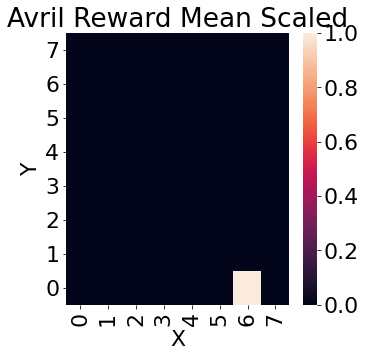

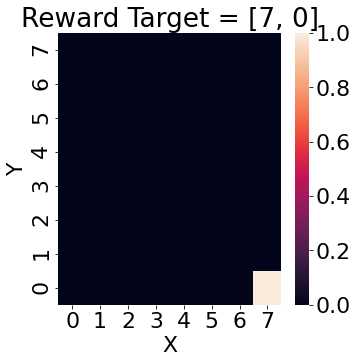

In [47]:
# This is on-policy. We're recommending actions, not predicting rewards right.
heatmap_reward = np.zeros((8, 8))
target_state = [7, 0]
for i, x_i in enumerate(range(8)):
    for j, y_i in enumerate(range(8)):
        state = transform_state([x_i, y_i])
        action_logit = agent.predict(jnp.array(state, jnp.float32))
        action = jax.nn.softmax(action_logit).argmax()
        ns = calculate_next_state(state, action)
        if ns == [7, 0]:
            heatmap_reward[y_i, x_i] = 1

x = np.arange(0, 8, 1)
y = np.arange(0, 8, 1)
heatmap_reward = (heatmap_reward - np.min(heatmap_reward))/np.ptp(heatmap_reward)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(5)
ax = sns.heatmap(heatmap_reward)
plt.title("Avril Reward Mean Scaled")
ax.invert_yaxis()
plt.xlabel("X")
plt.ylabel("Y")
ax.set_xticklabels(x, rotation=90)
ax.set_yticklabels(y, rotation=360)
plt.show()
plt.close()

plot_reward(n=8, title="Reward Target = [7, 0]", target_state=[7, 0])